## Import libraries

In [1]:
import nilearn as nil
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from nilearn import image
from nilearn import masking
#from nilearn.plotting import image
from pathlib import Path

## Read in fmri data

In [2]:
fMRI_folder = Path('./doi_10.5061_dryad.gt413__v1')
assert fMRI_folder.exists(), f"Foldder: {fMRI_folder} does not exist."

mat_files = sorted(list(fMRI_folder.glob('subject_*.mat')))

## Build 4d matrix

In [3]:
# Builds a matrix of shape (x,y,z,nTRs) for a subject
#
# Params: 
# x_dim: maximum x coord
# y_dim: maximum y coord
# z_dim: maximum z coord
# nTRs: number of total fmri scans
# data: fmri data of shape (nTRs, nVoxels)
# colToCoord: maps each voxel in data to its 3d coordinates
#
# Returns: matrix of shape (x,y,z,nTRs) with each voxel having its BOLD data

def build_4d_matrix(x_dim,y_dim,z_dim,nTRs,data,colToCoord):
    matrix = np.zeros((x_dim,y_dim,z_dim,nTRs))
    #print(matrix.shape)
    for voxel_id in range(data.shape[1]):
        x,y,z = colToCoord[voxel_id]
        matrix[x-1, y-1, z-1, :] = data[:,voxel_id]
    return matrix

dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 37913)
(53, 60, 50, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 33740)
(51, 60, 49, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 29307)
(53, 59, 47, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 26851)
(53, 59, 44, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 27073)
(51, 59, 45, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 34837)
(49, 56, 51, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 30689)
(52, 60, 49, 1351)
dict_keys(['__header__', '__version__', '__globals__', 'data', 'time', 'words', 'meta'])
(1351, 31047)
(52, 60, 48, 1351)


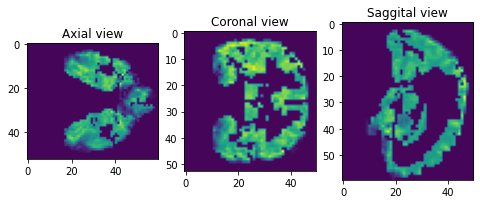

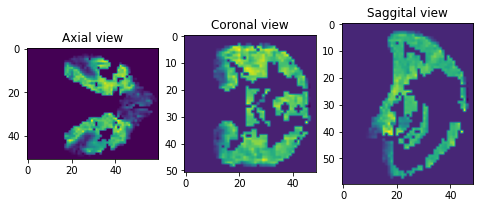

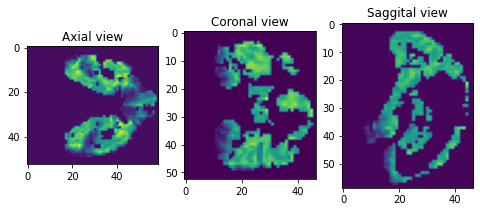

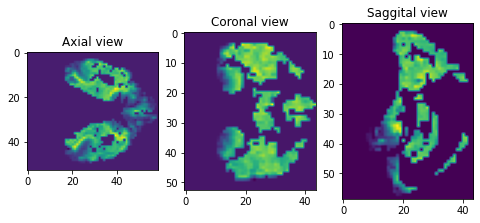

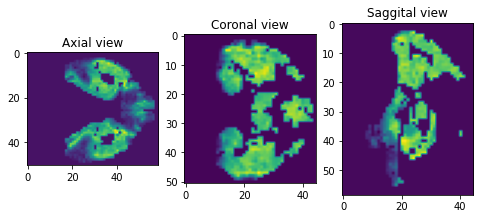

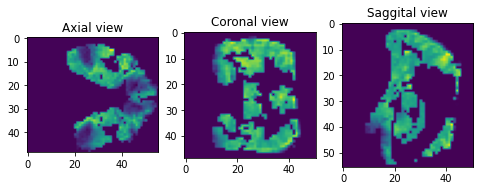

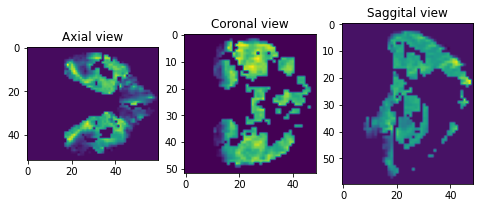

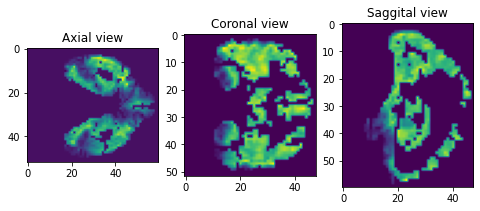

In [8]:
affine_4d = np.eye(4,4)

subjects_4d = []
for f in mat_files:
    mat_contents = sio.loadmat(f)
    print(mat_contents.keys())
    #print(type(mat_contents['data']))
    print(mat_contents['data'].shape)
    #print('({x}, {y}, {z})'.format(x=mat_contents['meta']['dimx'][0][0][0][0], y=mat_contents['meta']['dimy'][0][0][0][0], z=mat_contents['meta']['dimz'][0][0][0][0]))
    n_TRs = mat_contents['data'].shape[0]
    data_4d = build_4d_matrix(mat_contents['meta']['dimx'][0][0][0][0], mat_contents['meta']['dimy'][0][0][0][0], mat_contents['meta']['dimz'][0][0][0][0], n_TRs, mat_contents['data'], mat_contents['meta']['colToCoord'][0][0])
    print(data_4d.shape)
    subjects_4d.append(data_4d)
    
    img_nii_4d = nib.Nifti1Image(data_4d[:,:,:,:], affine_4d)
    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(img_nii_4d.get_fdata()[:,:,16,0])
    axes[0].set_title('Axial view');
    axes[1].imshow(img_nii_4d.get_fdata()[:,32,:,0])
    axes[1].set_title('Coronal view');
    axes[2].imshow(img_nii_4d.get_fdata()[32,:,:,0])
    axes[2].set_title('Saggital view');

## Smoothing

In [5]:
import os.path as op
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

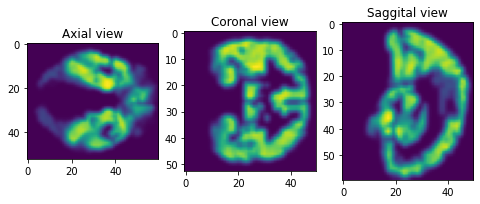

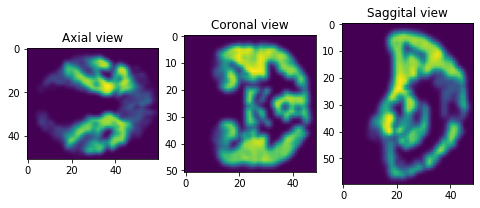

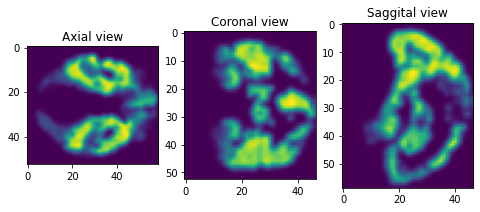

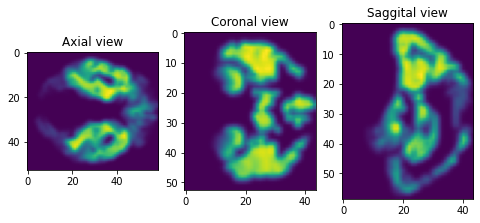

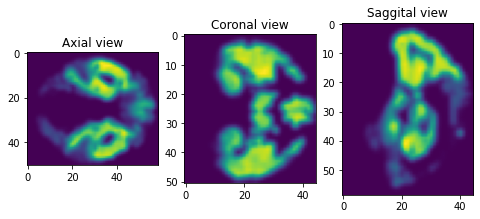

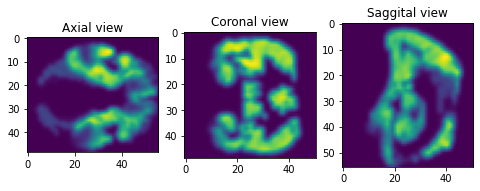

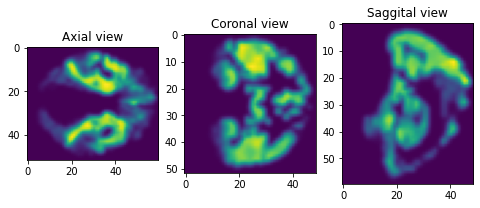

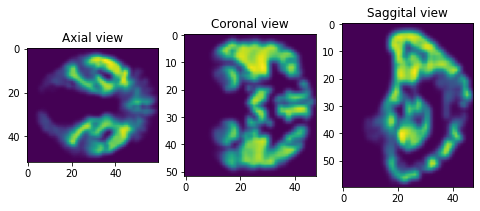

In [6]:
# Taken from https://lukas-snoek.com/NI-edu/fMRI-introduction/week_4/spatial_preprocessing.html
affine_4d = np.eye(4,4)

for subj_id, subj_4d in enumerate(subjects_4d):
    fwhm = 6
    voxelsize = 3
    data_4d_smoothed = np.zeros(subj_4d.shape)
    
    for x in range(subj_4d.shape[3]):
        vol = subj_4d[:, :, :, x]
        sigma = fwhm / (np.sqrt(8 * np.log(2)) * voxelsize)
        smoothed_vol = gaussian_filter(vol, sigma=sigma)
        data_4d_smoothed[:,:,:,x] = smoothed_vol
    
    smooth_file_name = str(subj_id) + '_smooth_nifti_4d.nii'
    smooth_img_nii_4d = nib.Nifti1Image(data_4d_smoothed[:,:,:,:], affine_4d)
    nib.save(smooth_img_nii_4d, fMRI_folder / smooth_file_name)
    
    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(smooth_img_nii_4d.get_fdata()[:,:,16,0])
    axes[0].set_title('Axial view');
    axes[1].imshow(smooth_img_nii_4d.get_fdata()[:,32,:,0])
    axes[1].set_title('Coronal view');
    axes[2].imshow(smooth_img_nii_4d.get_fdata()[32,:,:,0])
    axes[2].set_title('Saggital view');

## Detrending

OSError: [Errno 22] Invalid argument: 'doi_10.5061_dryad.gt413__v1\\7_detrend_nifti_4d.nii'

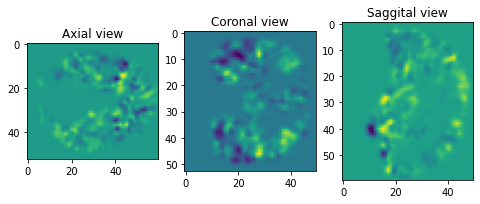

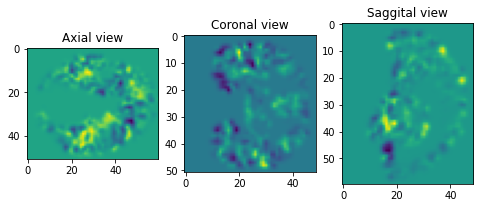

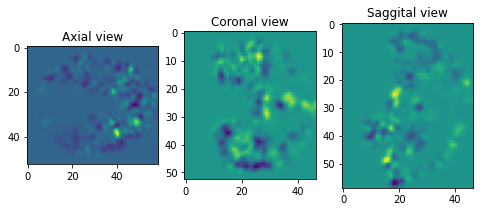

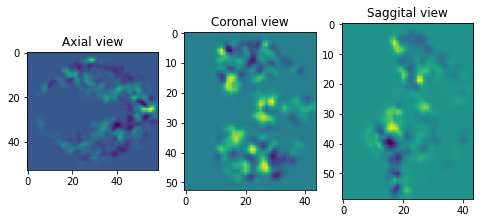

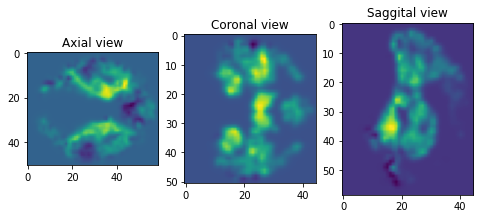

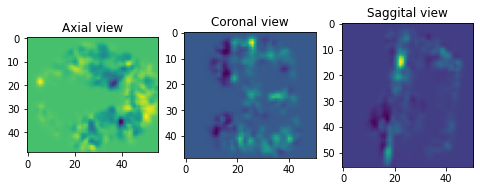

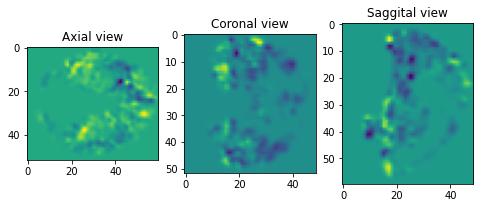

In [33]:
for subj_id in range(len(subjects_4d)):
    smooth_file_name = str(subj_id) + '_smooth_nifti_4d.nii'
    nii_4D = fMRI_folder / smooth_file_name
    detrend_4d = image.clean_img(nii_4D, detrend=True, standardize=False, t_r=2)
    #detrend_4d = image.clean_img(nii_4D, detrend=False, standardize=False, t_r=2, high_pass=0.005)
    detrend_file_name = str(subj_id) + '_detrend_nifti_4d.nii'
    nib.save(detrend_4d, fMRI_folder / detrend_file_name)
    
    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(detrend_4d.get_fdata()[:,:,16,0])
    axes[0].set_title('Axial view');
    axes[1].imshow(detrend_4d.get_fdata()[:,32,:,0])
    axes[1].set_title('Coronal view');
    axes[2].imshow(detrend_4d.get_fdata()[32,:,:,0])
    axes[2].set_title('Saggital view');

## Masking

(53, 60, 50, 1351)
(53, 60, 50)
(1351, 41773)
(51, 60, 49, 1351)
(51, 60, 49)
(1351, 38871)
(53, 59, 47, 1351)
(53, 59, 47)
(1351, 37448)
(53, 59, 44, 1351)
(53, 59, 44)
(1351, 36393)
(51, 59, 45, 1351)
(51, 59, 45)
(1351, 34614)
(49, 56, 51, 1351)
(49, 56, 51)
(1351, 34789)
(52, 60, 49, 1351)
(52, 60, 49)
(1351, 41364)
(52, 60, 48, 1351)
(52, 60, 48)
(1351, 36424)


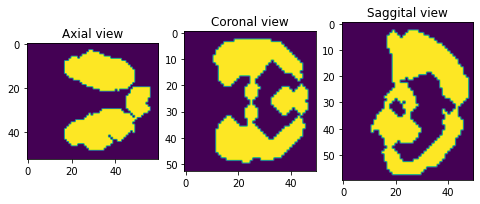

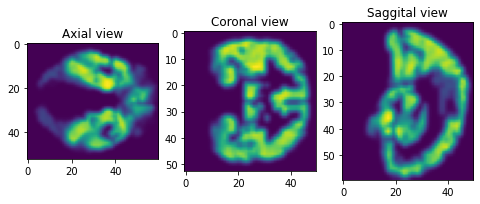

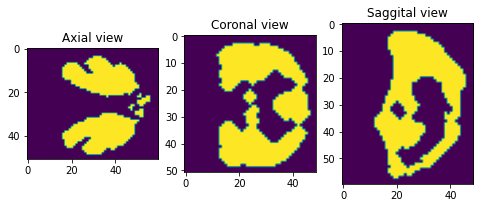

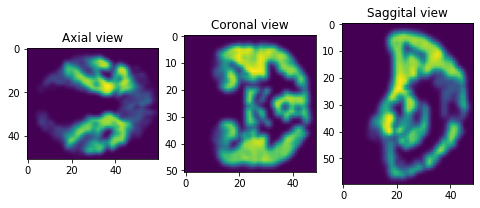

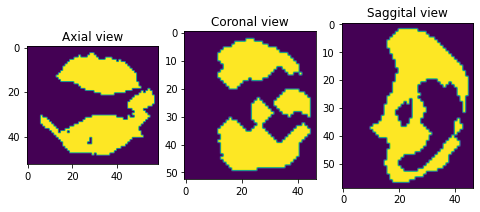

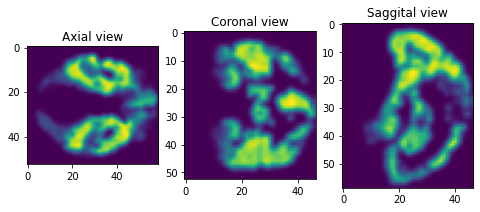

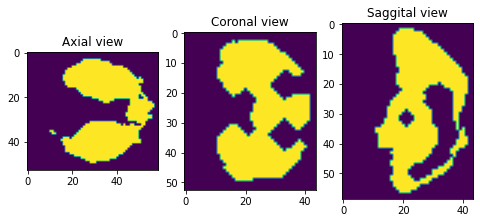

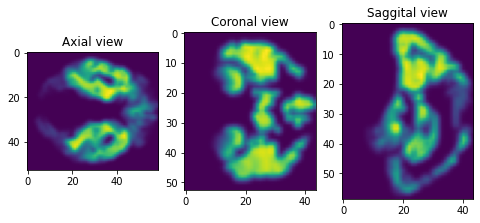

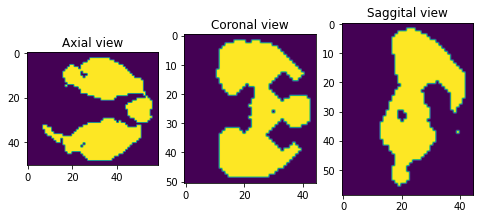

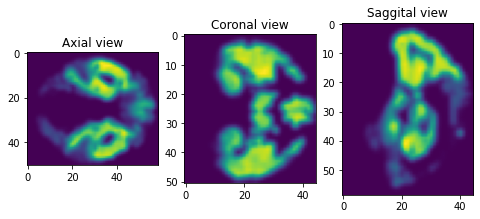

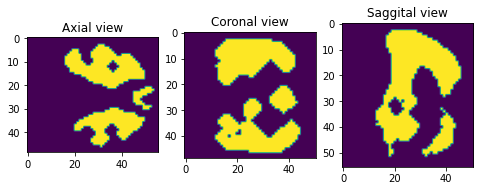

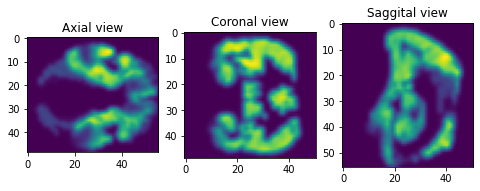

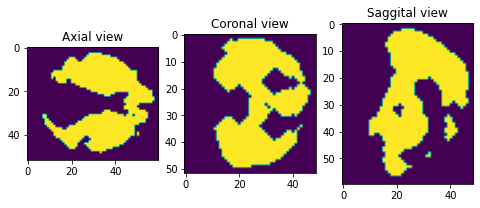

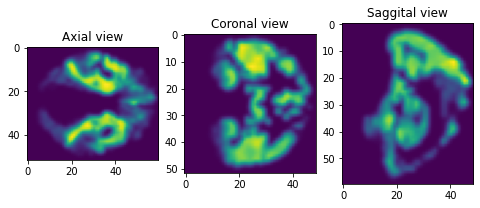

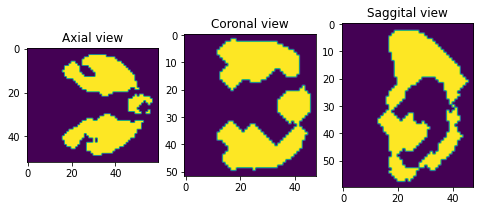

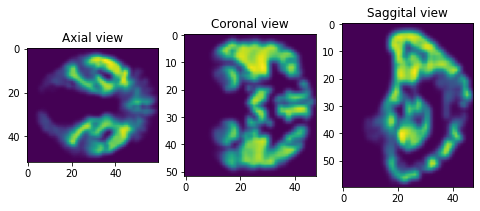

In [7]:
for subj_id in range(len(subjects_4d)):
    smooth_file_name = str(subj_id) + '_smooth_nifti_4d.nii'
    #detrend_file_name = str(subj_id) + '_detrend_nifti_4d.nii'
    #nii_4D = fMRI_folder / detrend_file_name
    nii_4D = fMRI_folder / smooth_file_name
    mask = masking.compute_epi_mask(nii_4D, lower_cutoff=0.2, upper_cutoff=0.75)
                                    
    data_mc = nib.load(nii_4D)
    masked_2d = masking.apply_mask(nii_4D, mask)
    
    print(data_mc.shape)
    print(mask.get_fdata().shape)
    print(masked_2d.shape)
    
    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(mask.get_fdata()[:,:,16])
    axes[0].set_title('Axial view');
    axes[1].imshow(mask.get_fdata()[:,32,:])
    axes[1].set_title('Coronal view');
    axes[2].imshow(mask.get_fdata()[32,:,:])
    axes[2].set_title('Saggital view');
    
    fig, axes = plt.subplots(1,3, figsize=(8,15))
    axes = np.ravel(axes)
    axes[0].imshow(data_mc.get_fdata()[:,:,16,0])
    axes[0].set_title('Axial view');
    axes[1].imshow(data_mc.get_fdata()[:,32,:,0])
    axes[1].set_title('Coronal view');
    axes[2].imshow(data_mc.get_fdata()[32,:,:,0])
    axes[2].set_title('Saggital view');
    
    mask_file_name = str(subj_id) + '_masked_2d.npy'
    np.save(fMRI_folder / mask_file_name, masked_2d)